# Fraudulent Activities - PART I

### OBJECTIF

Les sites de E-commerce font transiter beaucoup d'argent. Cela peut engendrer des risques non négligeables d'activités frauduleuses, comme l'utilisation de carte de crédit volées, du blanchiment d'argent, etc.

Fort heureusement, le Machine Learning peut nous aider à identifier ces activités frauduleuses. Tous les sites web où vous devez entrer vos informations de paiements ont une équipe qui s'occupe de gérer les risques de fraude via le ML.

Le but de ce challenge est de construire un modèle qui vous permet de prédire une probabilité de transaction frauduleuse.

### DESCRIPTION

L'entreprise X fait du E-commerce et vend des vêtements faits-main. Votre but est de construire un modèle qui permette de prédire si l'achat d'un vêtement doit être considéré comme une transaction frauduleuse ou non.

Voici précisément ce que vous devez faire :

1. Pour chacun des utilisateurs, déterminez le pays d'origine depuis son adresse IP

2. Construisez un modèle qui permette de prédire si l'activité est frauduleuse ou non. Expliquez aussi vos choix / hypothèses en termes d'optimisation de faux-positifs et faux-négatifs

3. Votre patron aimerait comprendre votre modèle car il est inquiet d'utiliser un modèle _black box_. Comment l'expliqueriez vous d'un point utilisateur, et non pas mathématique. Par exemple, quels sont les utilisateurs qui peuvent être classés comme _risqués_ ?

4. Supposons que vous pouvez utiliser votre modèle en live pour qu'il fasse sa prédiction en temps réel. D'un point de vue Produit, comment l'utiliseriez-vous ? Comment pourriez-vous penser l'expérience utilisateur face à ce produit ?


### DATA

Vous pouvez utiliser les deux tables suivantes :

```python
Fraud_Data
```

&

```python
IpAddress_to_Country
```


#### Import labraries 

In [148]:
# import libraries

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from datetime import timedelta

pd.options.display.max_columns = None

from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder

## 1 - Loading and checking data type and structure of the datasets

In [67]:
# Read csv files 

fraud_data = pd.read_csv('../Data/Fraud_Data.csv') # dataset with samples of transactions. Target Y with two class, 0: not fraud, 1: fraud
ip_data = pd.read_csv('../Data/IpAddress_to_Country.csv') # file with boundaries ip adress by country

display(fraud_data.head())
display(ip_data.head())

user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0

lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China
2              16777728.0                16778239      China
3              16778240.0                16779263  Australia
4              16779264.0                16781311      China

In [68]:
# function which merge datasets fraud_data & ip_data from 'ip...' features already used

#def transform_ip(arg) :
    #try :
        #return ip_data.country[(ip_data.lower_bound_ip_address < arg) & (ip_data.upper_bound_ip_address > arg)].iloc[0]
    #except IndexError :
        #return "Pays inconnu"  

#fraud_data["country_name"] = fraud_data.ip_address.apply(transform_ip) 

#fraud_data.to_csv('fraud_data_country.csv') # save the dataset just merged in the event of a next using

In [69]:
# Read csv file just saved and merged

fraud_data = pd.read_csv('../Data/fraud_data_country.csv', index_col=0)
df = fraud_data.copy()

# Some exploration about the dataset

print("Display of dataset: ")
display(fraud_data.head()) # display the first five row of the dataset
print()

print("Basics statistics: ")
data_desc = fraud_data.describe(include='all') # describing the main statistics info of the dataset
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*fraud_data.isnull().sum()/fraud_data.shape[0]) # give the percentage of null values for each variable
print()

display(fraud_data.info()) # display main info about the structure of the dataset

Display of dataset: 


user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class   country_name  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0          Japan  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  United States  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  United States  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0   Pays inconnu  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  United States


Basics statistics: 


user_id          signup_time        purchase_time  \
count   151112.000000               151112               151112   
unique            NaN               151112               150679   
top               NaN  2015-06-06 14:50:45  2015-07-17 23:22:55   
freq              NaN                    1                    3   
mean    200171.040970                  NaN                  NaN   
std     115369.285024                  NaN                  NaN   
min          2.000000                  NaN                  NaN   
25%     100642.500000                  NaN                  NaN   
50%     199958.000000                  NaN                  NaN   
75%     300054.000000                  NaN                  NaN   
max     400000.000000                  NaN                  NaN   

        purchase_value      device_id  source browser     sex            age  \
count    151112.000000         151112  151112  151112  151112  151112.000000   
unique             NaN         137956       3       5       2            NaN   
top                NaN  ITUMJCKWEYNDD     SEO  Chrome       M            NaN   
freq               NaN             20   60615   61432   88293            NaN   
mean         36.935372            NaN     NaN     NaN     NaN      33.140704   
std          18.322762            NaN     NaN     NaN     NaN       8.617733   
min           9.000000            NaN     NaN     NaN     NaN      18.000000   
25%          22.000000            NaN     NaN     NaN     NaN      27.000000   
50%          35.000000            NaN     NaN     NaN     NaN      33.000000   
75%          49.000000            NaN     NaN     NaN     NaN      39.000000   
max         154.000000            NaN     NaN     NaN     NaN      76.000000   

          ip_address          class   country_name  
count   1.511120e+05  151112.000000         151112  
unique           NaN            NaN            182  
top              NaN            NaN  United States  
freq             NaN            NaN          58049  
mean    2.152145e+09       0.093646            NaN  
std     1.248497e+09       0.291336            NaN  
min     5.209350e+04       0.000000            NaN  
25%     1.085934e+09       0.000000            NaN  
50%     2.154770e+09       0.000000            NaN  
75%     3.243258e+09       0.000000            NaN  
max     4.294850e+09       1.000000            NaN


Percentage of missing values: 


user_id           0.0
signup_time       0.0
purchase_time     0.0
purchase_value    0.0
device_id         0.0
source            0.0
browser           0.0
sex               0.0
age               0.0
ip_address        0.0
class             0.0
country_name      0.0
dtype: float64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
 11  country_name    151112 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 15.0+ MB


None

As we can see :
 - we have a dataset with 12 columns and 151 112 rows
 - There is no feature with null values
 - we have features with different data types
 - we have features which are numerical and others which are categorical

## 1 - PREPROCESSING

#### We will be doing some preprocessing operations with some features in order to transform some of them for analyzing and to make them some understable for the ML models

In [70]:
# droping user_id feature not useful. However, we keep ip_adress and device_id

#to_remove = ['user_id']
#df = df[[c for c in df.columns if c not in to_remove ]] 

In [71]:
# Changing data type for time features "signup_time" & "purchase_time"

df.loc[:, 'signup_time'] =  pd.to_datetime(df.loc[:, 'signup_time'],
                                                   format='%Y-%m-%d %H:%M:%S')
df.loc[:, 'purchase_time'] =  pd.to_datetime(df.loc[:, 'purchase_time'],
                                                     format='%Y-%m-%d %H:%M:%S')

Time features : we take some information from time features to create distinct features which will be usefull for the models. We keep month, day,    day_name and hour. Year is out of bag because all events has occured in 2015.

In [72]:
# creating new features from signup_time & purchase_time

df['signup_month'] = df['signup_time'].dt.month
df['signup_day'] = df['signup_time'].dt.day
df['signup_day_name'] = df['signup_time'].dt.day_name()
df['signup_hour'] = df['signup_time'].dt.hour

df['purchase_month'] = df['purchase_time'].dt.month
df['purchase_day'] = df['purchase_time'].dt.day
df['purchase_day_name'] = df['purchase_time'].dt.day_name()
df['purchase_hour'] = df['purchase_time'].dt.hour

In [74]:
# creature a feature call "time_to_purchase" to measure time spent between the sign up and the purchase

seconds_in_day = 24 * 60 * 60 # to have total second in a day 

# we take the diffence between sign up and purchase and we transform it in second measure unit
df['time_to_purchase'] = df['purchase_time'] - df['signup_time']
df['time_to_purchase'] = df['time_to_purchase'].dt.days * seconds_in_day + df['time_to_purchase'].dt.seconds

# we remove old time features
#to_remove = ['signup_time', 'purchase_time']
#df = df[[c for c in df.columns if c not in to_remove ]] 

# Read the first five rows to check transformations
df.head(5)

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class   country_name  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0          Japan   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  United States   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  United States   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0   Pays inconnu   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  United States   

   signup_month  signup_day signup_day_name  signup_hour  purchase_month  \
0             2          24         Tuesday           22               4   
1             6           7          Sunday           20               6   
2             1           1        Thursday           18               1   
3             4          28         Tuesday           21               5   
4             7          21         Tuesday            7               9   

   purchase_day purchase_day_name  purchase_hour  time_to_purchase  
0            18          Saturday              2           4506682  
1             8            Monday              1             17944  
2             1          Thursday             18                 1  
3             4            Monday             13            492085  
4             9         Wednesday             18           4361461

Ip_adresse : we use this feature to create an other feature with the count of occurence for each ip adresse

In [75]:
# count occurence for each ip dresse
count_ip_adr = df['ip_address'].value_counts()
#count_dev_id = df['device_id'].value_counts()

# create features with their occurence counting
df['count_ip_adr'] = df['ip_address'].apply(lambda x : count_ip_adr[x])
#df['count_device_id'] = df['device_id'].apply(lambda x : count_dev_id[x])

df.head()

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class   country_name  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0          Japan   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  United States   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  United States   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0   Pays inconnu   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  United States   

   signup_month  signup_day signup_day_name  signup_hour  purchase_month  \
0             2          24         Tuesday           22               4   
1             6           7          Sunday           20               6   
2             1           1        Thursday           18               1   
3             4          28         Tuesday           21               5   
4             7          21         Tuesday            7               9   

   purchase_day purchase_day_name  purchase_hour  time_to_purchase  \
0            18          Saturday              2           4506682   
1             8            Monday              1             17944   
2             1          Thursday             18                 1   
3             4            Monday             13            492085   
4             9         Wednesday             18           4361461   

   count_ip_adr  
0             1  
1             1  
2            12  
3             1  
4             1

## 2 - ANALYZE

#### Not fraud vs fraud  distribution and sex distribution

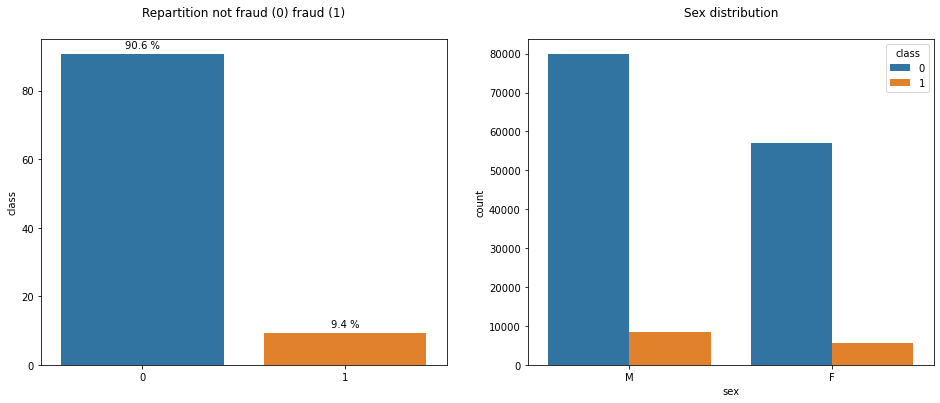

In [76]:
# create fig and axes
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize=(16, 6))

# plot the class distribution
splot_class = sns.barplot(x = df['class'].value_counts().index,
                          y = df['class'].value_counts()/len(df)*100,
                          data = df, ax = ax1)
# annotate percentage
for p in splot_class.patches:
    splot_class.annotate(format(p.get_height(), '.1f')+' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# plot the sex distribution
sns.countplot(x= 'sex', data = df, hue='class', ax = ax2)

# add title to the plots
ax1.set_title('Repartition not fraud (0) fraud (1)', y=1.05)
ax2.set_title('Sex distribution', y=1.05)

plt.show()

- On the grid above we can see the target class are strictely imbalanced. Hence we will pay attention about it later on. 
- Sex distribution with fraud or without fraud is quiet the same.

#### Distribution for several features in order to try to hightlight patterns between purchase and fraud

[]

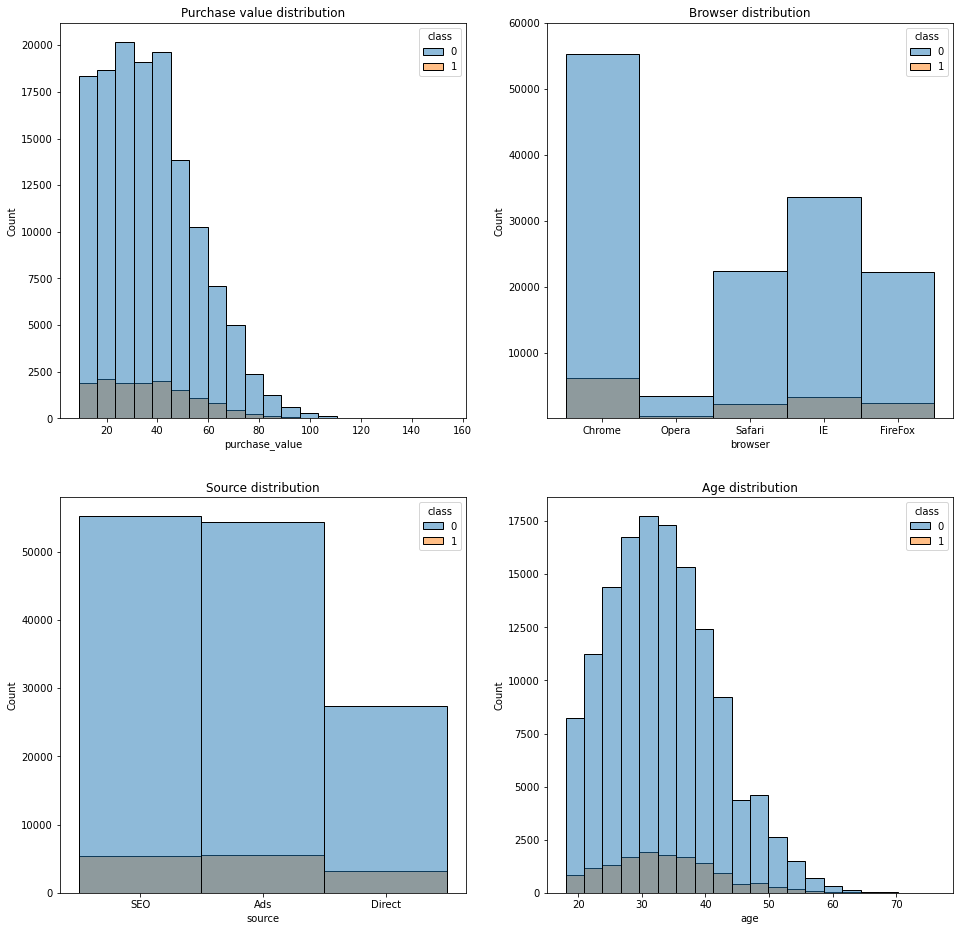

In [77]:
# create fig and axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2 , 2, figsize=(16,16))

# plot distrubutions
sns.histplot(x="purchase_value", data = df, hue='class', bins=20, ax=ax1)
sns.histplot(x="browser", data = df, hue='class', ax=ax2)
sns.histplot(x="source", data = df, hue='class', ax=ax3)
sns.histplot(x="age", data = df, hue='class', bins=20, ax=ax4)

# change y scale for ax2
ax2.set(ylim=(10, 60000))

# add title to the plots
ax1.set_title('Purchase value distribution')
ax2.set_title('Browser distribution')
ax3.set_title('Source distribution')
ax4.set_title('Age distribution')

plt.plot()

On the grid above we can see the distribution of 4 features. For each of theme the ratio between fraud or not fraud is quiet the same. So perhaps they won't be really usefull to predict fraud but we make the choice to keep them all for ML models.

#### Distribution fraud per country

In [78]:
# total transaction per country
total_tr_country = pd.DataFrame(df['country_name'].value_counts(ascending=True))
total_tr_country = total_tr_country.rename(columns = {'country_name' : 'total_transaction'})

# total number of fraud per country
total_frd_per_country = pd.DataFrame(df['country_name'][df['class'] == 1]
                                 .value_counts().sort_values(ascending = True))
total_frd_per_country = total_frd_per_country.rename(columns = {'country_name': 'total_fraud'})

# percentage fraud within each country
perc_frd_per_country = (df.loc[df['class'] == 1, 'country_name']
                     .value_counts()/df['country_name'].value_counts())*100

# transform perc_1_in_country in DataFrame
perc_frd_per_country = pd.DataFrame(np.round(perc_frd_per_country.sort_values(ascending = False), 2))
perc_frd_per_country = perc_frd_per_country.rename(columns = {'country_name': 'perc_fraud'})

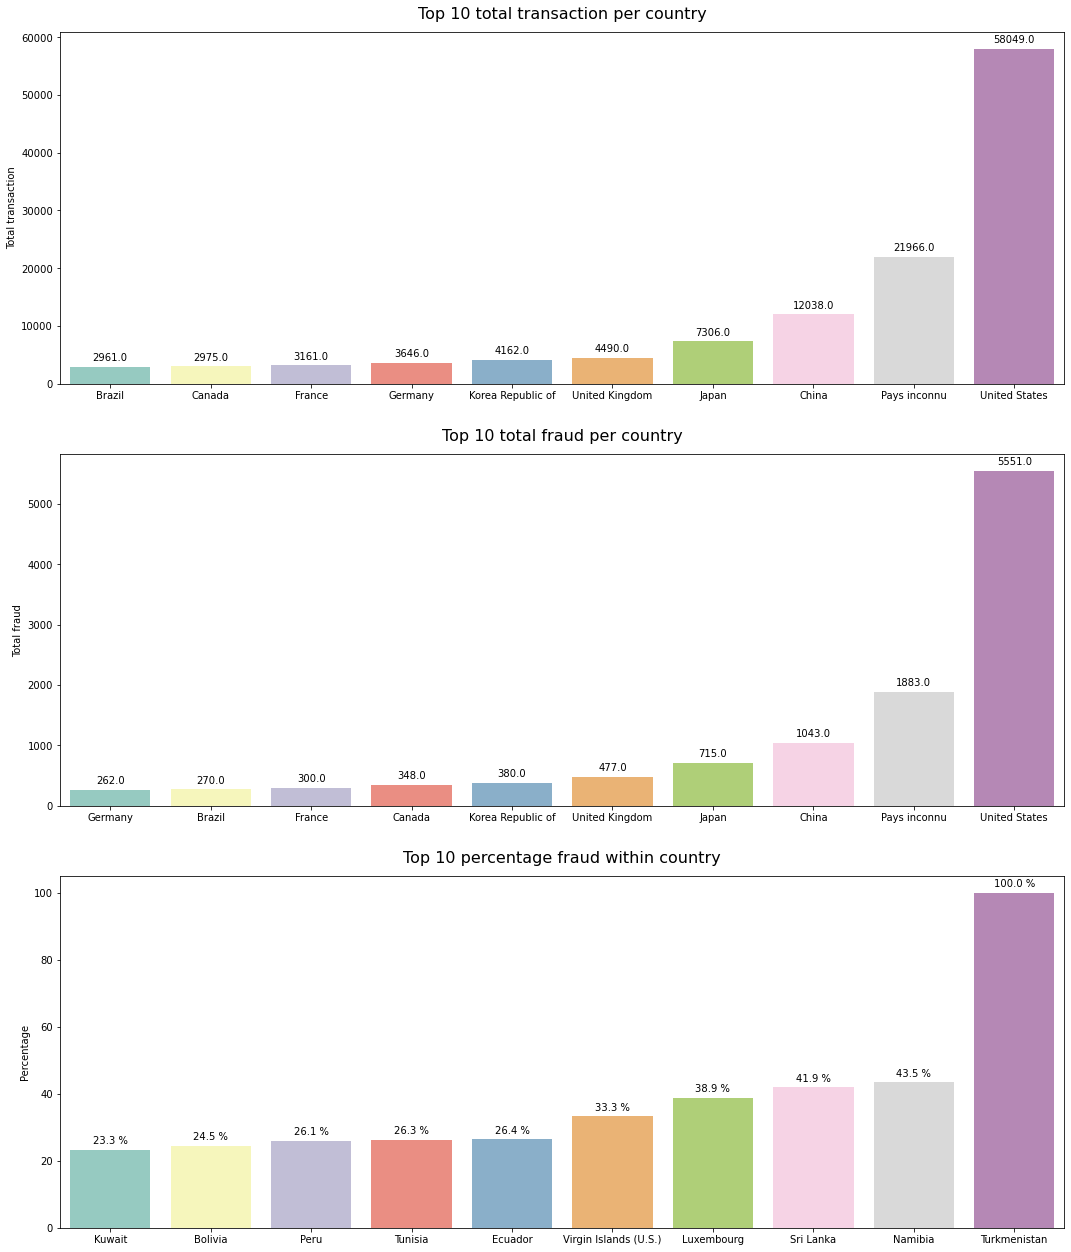

In [79]:
# create fig and axes
fig, ((ax1, ax2, ax3)) = plt.subplots(3,1, figsize=(18, 22))

# plot total transaction for 10 first country
splot_c = sns.barplot(x = total_tr_country[-10:].index , y = 'total_transaction', 
                      data = total_tr_country[-10:], ax=ax1, palette="Set3")
# annotte values
for p in splot_c.patches:
    splot_c.annotate(format(p.get_height(), '.1f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

# plot total number of fraud for 10 first country
splot_t = sns.barplot(x = total_frd_per_country[-10:].index , y = 'total_fraud', 
                      data = total_frd_per_country[-10:], ax=ax2, palette="Set3")
# annotte values
for p in splot_t.patches:
    splot_t.annotate(format(p.get_height(), '.1f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

# plot percentage fraud within each country 10 first country
splot_p = sns.barplot(x = perc_frd_per_country[:10].sort_values('perc_fraud', ascending = True).index , y = 'perc_fraud', 
                      data = perc_frd_per_country[:10].sort_values('perc_fraud', ascending = True), ax=ax3, palette="Set3")
# annotate percentages
for p in splot_p.patches:
    splot_p.annotate(format(p.get_height(), '.1f')+' %', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

# add title
ax1.set_title('Top 10 total transaction per country', y = 1.02, size=16)
ax2.set_title('Top 10 total fraud per country', y = 1.02, size=16)
ax3.set_title('Top 10 percentage fraud within country', y = 1.02, size=16)

# change y labels
ax1.set_ylabel('Total transaction')
ax2.set_ylabel('Total fraud')
ax3.set_ylabel('Percentage')

plt.draw()

- On the second plot above we can see the higher numbers of fraud come frome developped countries. This result can be surprising but in fact it does'nt. Indeed, more people have a web access and a device which make possible to realize purchase on the website. There is a logic proportionnality regarding the 2 first plots, the countries are the same. However, becarefull to the second position "Pays-inconnus" (unknown country) which can impact the analyze.
- On the third plot the results are strongly different. Indeed, we can see that the highers percentage of fraud within a country come from undevelopped or developping countries. Regarding the first and second plot, for developped country the percentage of the top 10 seems to be around 10% while for undevelopped or developping country its from 23% to 100%. However, there is 2 strangers in this group, a US Federal State and Luxembourg.
In fact it could be really usefull to use the percentage fraud within country to predict fraud in ML models

In [80]:
# add feature percentage fraud

df['perc_fraud'] = df['country_name'].apply(lambda x : np.round(perc_frd_per_country.loc[x, 'perc_fraud'], 2))
df.head()

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class   country_name  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0          Japan   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  United States   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  United States   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0   Pays inconnu   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  United States   

   signup_month  signup_day signup_day_name  signup_hour  purchase_month  \
0             2          24         Tuesday           22               4   
1             6           7          Sunday           20               6   
2             1           1        Thursday           18               1   
3             4          28         Tuesday           21               5   
4             7          21         Tuesday            7               9   

   purchase_day purchase_day_name  purchase_hour  time_to_purchase  \
0            18          Saturday              2           4506682   
1             8            Monday              1             17944   
2             1          Thursday             18                 1   
3             4            Monday             13            492085   
4             9         Wednesday             18           4361461   

   count_ip_adr  perc_fraud  
0             1        9.79  
1             1        9.56  
2            12        9.56  
3             1        8.57  
4             1        9.56

#### Purchase vs fraud considering count of ip adress

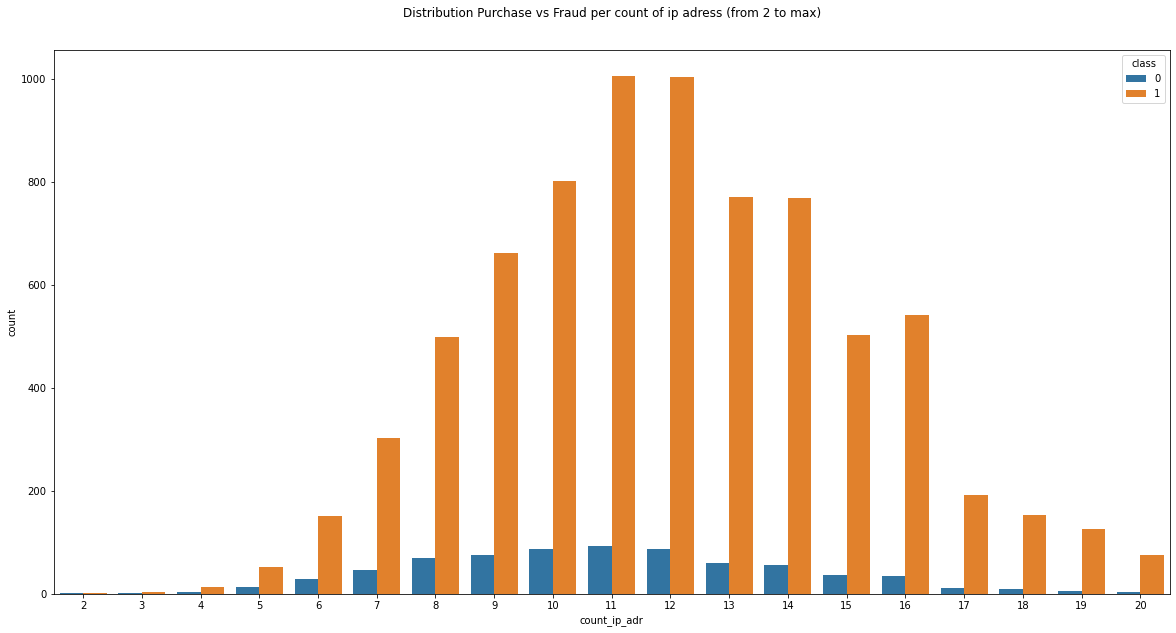

In [81]:
count_ip_adr_vs_class = df[['user_id',
                            'count_ip_adr',
                            'class']].groupby(['count_ip_adr',
                                               'class']).count().rename(columns={'user_id': 'count'})
count_ip_adr_vs_class = count_ip_adr_vs_class.reset_index()

fig, ax1 = plt.subplots(1, 1, figsize = (20, 10))
sns.barplot(x = 'count_ip_adr',
            y = 'count',
            data = count_ip_adr_vs_class[count_ip_adr_vs_class['count_ip_adr'] > 1],
            hue = 'class', ax = ax1)
ax1.set_title('Distribution Purchase vs Fraud per count of ip adress (from 2 to max)', y = 1.05)
plt.show()

The number of occurence for an ip adress have significatively an impact on fraud

#### Playing with date time features

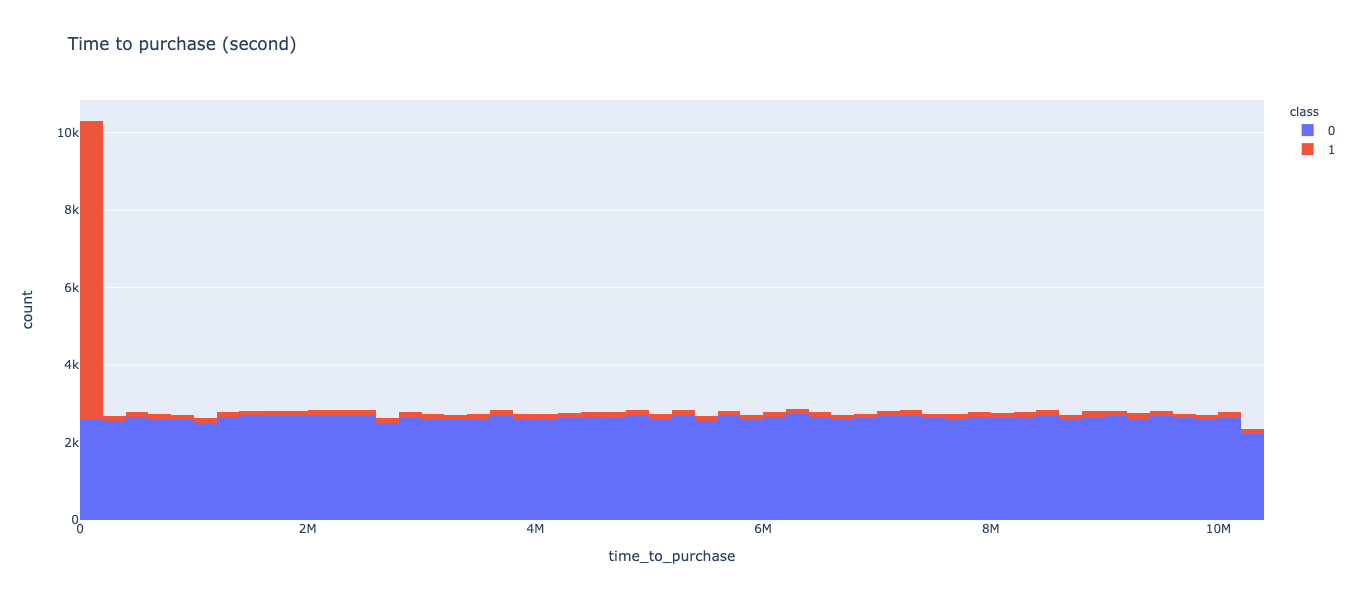

In [82]:
# plot time_to_purchase histogram with Plotly

fig = px.histogram(df, x = 'time_to_purchase', color = 'class',
                   title = 'Time to purchase (second)', nbins = 100,
                   width=800, height=600)

fig.show()

Most of the time for a fraud transaction the process from sign-up to purchase obviously take less time than a usual purchase. This feature can be usefull to predict fraud with ML models.

/Users/stephanesingery/opt/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




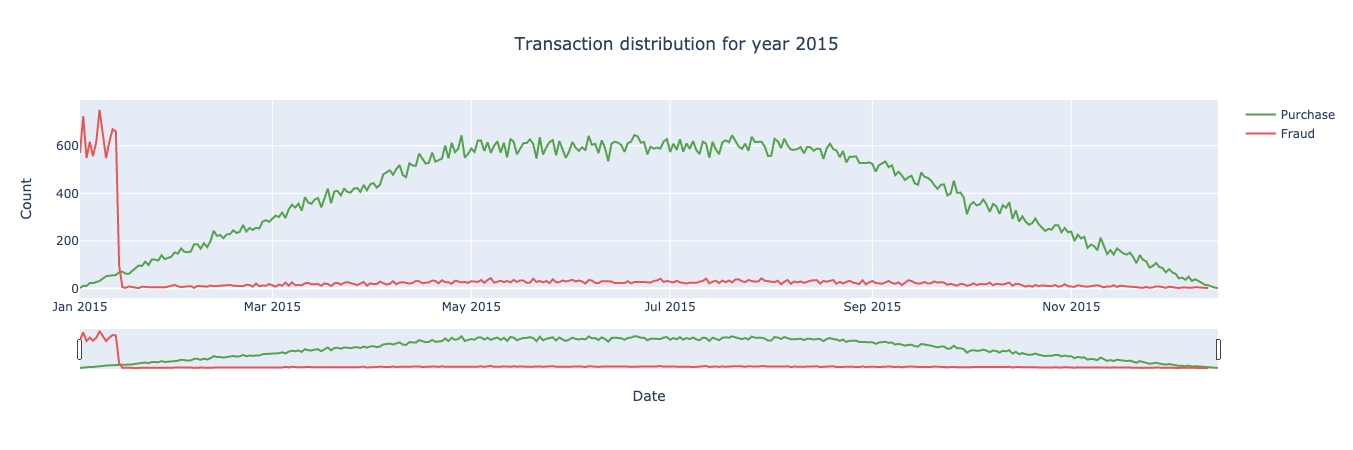

In [83]:

fraud_per_date = df['purchase_time'][df['class'] == 1].dt.date.value_counts()
fraud_per_date = pd.DataFrame(fraud_per_date).reset_index().rename(columns = 
                                                                   {'index': 'date', 
                                                                    'purchase_time': 'count_fraud'})
fraud_per_date = fraud_per_date.sort_values('date', ascending = True)


purch_per_date = df['purchase_time'][df['class'] == 0].dt.date.value_counts()
purch_per_date = pd.DataFrame(purch_per_date).reset_index().rename(columns = 
                                                                   {'index': 'date', 
                                                                    'purchase_time': 'count_purchase'})
purch_per_date = purch_per_date.sort_values('date', ascending = True)


fig_purch_per_date = go.Figure(
                        data = go.Line(
                            x = purch_per_date['date'],
                            y = purch_per_date['count_purchase'], 
                            name = 'Purchase',
                            line_color = '#54A24B'),
                        layout = go.Layout(
                            title = go.layout.Title(text = "Transaction distribution for year 2015", x = 0.5),
                            xaxis = go.layout.XAxis(title = 'Date', rangeslider = go.layout.xaxis.Rangeslider(visible = True)),
                            yaxis = go.layout.YAxis(title = 'Count')
                                          )
                              )

fig_purch_per_date.add_trace(go.Line(
                             x = fraud_per_date['date'],
                             y = fraud_per_date['count_fraud'],
                             name = 'Fraud',
                             line_color = '#E45756')
                            )
fig_purch_per_date.update_layout()
                             
fig_purch_per_date.show()

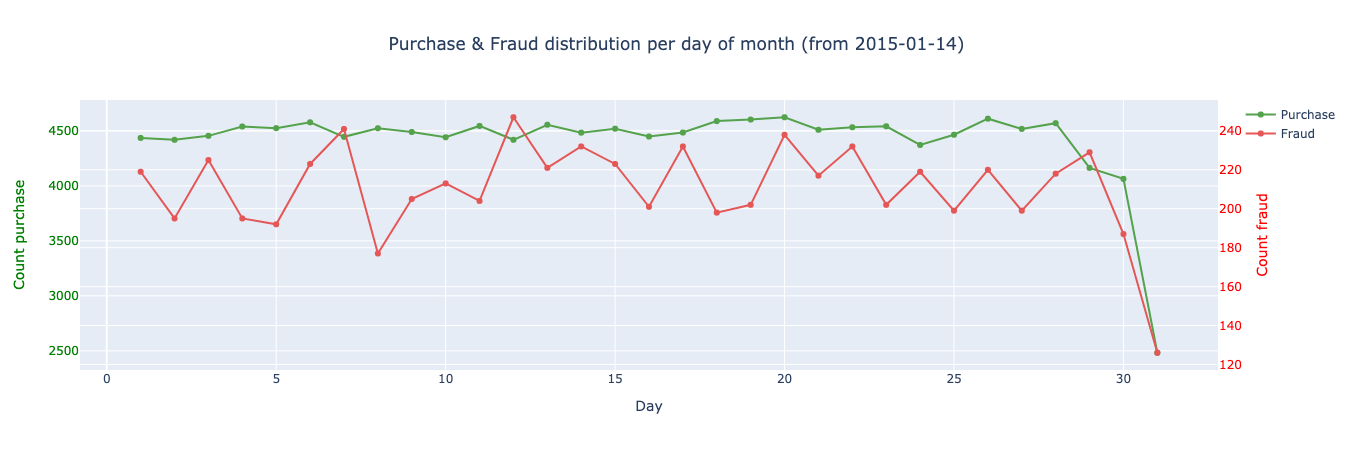

In [84]:
purch_per_day = df['purchase_day'][df['class'] == 0].value_counts()
purch_per_day = pd.DataFrame(purch_per_day).reset_index().rename(columns = 
                                                                {'index': 'day', 
                                                                 'purchase_day': 'count_purchase'})
purch_per_day = purch_per_day.sort_values('day', ascending = True)

fraud_per_day = df['purchase_day'][(df['class'] == 1) & (df['purchase_time'] > '2015-01-14')].value_counts()
fraud_per_day = pd.DataFrame(fraud_per_day).reset_index().rename(columns = 
                                                                {'index': 'day', 
                                                                 'purchase_day': 'count_fraud'})
fraud_per_day = fraud_per_day.sort_values('day', ascending = True)

fig_tr_per_day = go.Figure(
                        data = [go.Line(
                            x = purch_per_day['day'],
                            y = purch_per_day['count_purchase'], 
                            mode = 'lines+markers',
                            line_color = '#54A24B',
                            name = 'Purchase'),
                                go.Line(
                            x = fraud_per_day['day'],
                            y = fraud_per_day['count_fraud'], 
                            mode = 'lines+markers',
                            line_color = '#E45756',
                            name = "Fraud",
                            yaxis = 'y2')],
                        layout = go.Layout(
                            title = go.layout.Title(text = "Purchase & Fraud distribution per day of month (from 2015-01-14)", x = 0.5),
                            xaxis = go.layout.XAxis(title = 'Day'),
                            yaxis = go.layout.YAxis(title = 'Count purchase', color = 'green'),
                            yaxis2 = go.layout.YAxis(title = 'Count fraud', color = 'red', 
                                                     overlaying='y', side='right')
                                          )
                                      )                                             

fig_tr_per_day.show()

In [85]:
fraud_day_week = df['purchase_day_name'][df['class'] == 1].value_counts()
fraud_day_week = pd.DataFrame(fraud_day_week).reset_index().rename(columns = 
                                                                   {'index': 'day_name', 
                                                                    'purchase_day_name': 'count_fraud'})
fraud_day_week = fraud_day_week.sort_values('count_fraud', ascending = False)


purch_day_week = df['purchase_day_name'][df['class'] == 0].value_counts()
purch_day_week = pd.DataFrame(purch_day_week).reset_index().rename(columns = 
                                                                   {'index': 'day_name', 
                                                                    'purchase_day_name': 'count_purchase'})
tr_day_week = fraud_day_week.merge(purch_day_week)

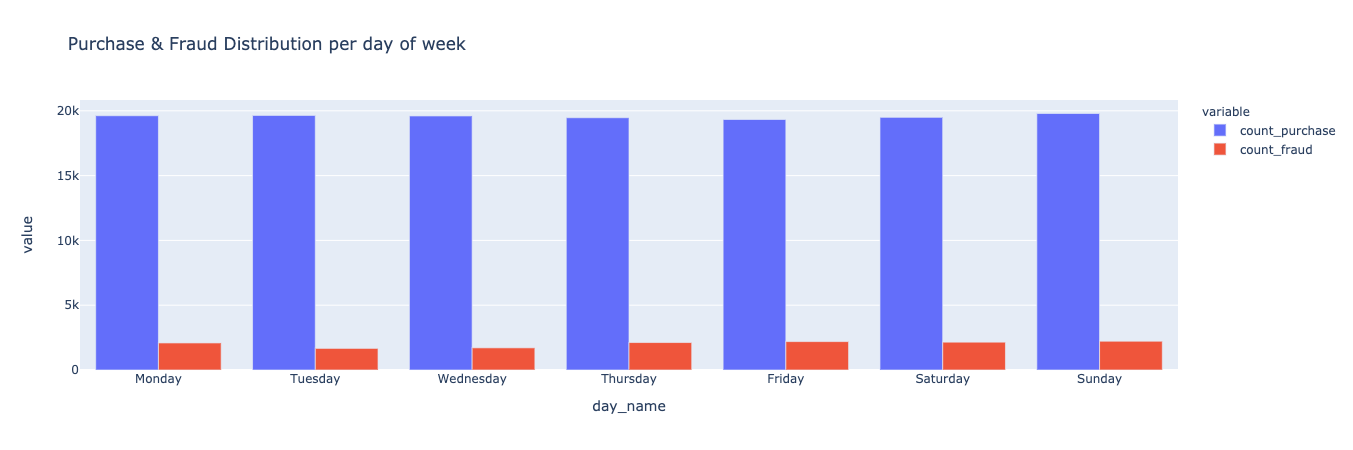

In [86]:
fig_day_week = px.bar(tr_day_week, x = "day_name",
                      y = ['count_purchase','count_fraud', ],
                      barmode="group",
                      category_orders = {"day_name": ["Monday", "Tuesday",
                                                               "Wednesday", "Thursday",
                                                               'Friday', 'Saturday',
                                                               'Sunday']},
                      title = 'Purchase & Fraud Distribution per day of week'
                     )

fig_day_week.show()

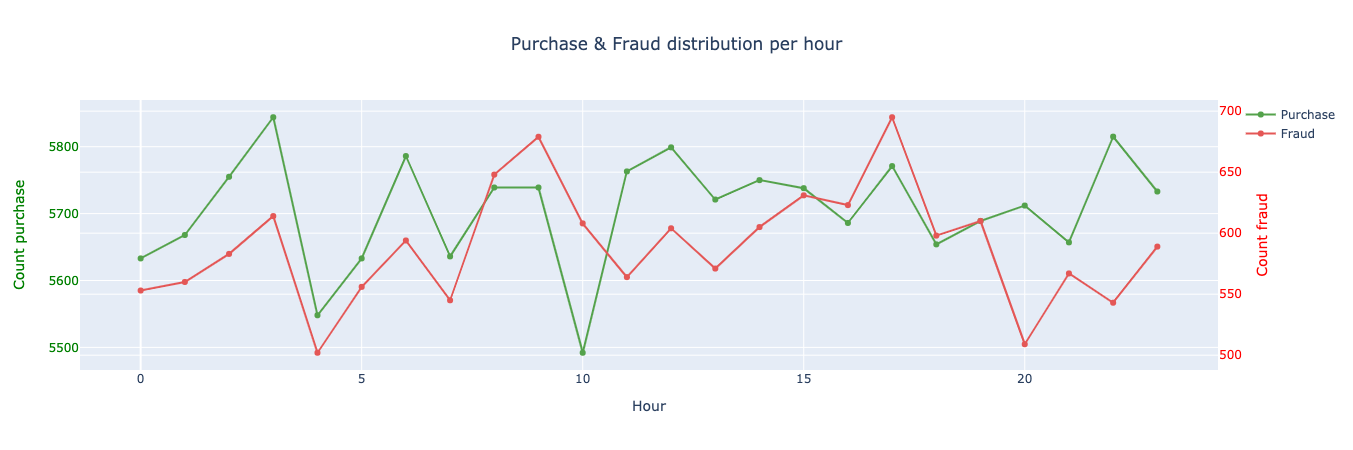

In [87]:
purch_per_hour = df['purchase_time'][df['class'] == 0].dt.hour.value_counts()
purch_per_hour = pd.DataFrame(purch_per_hour).reset_index().rename(columns = 
                                                                   {'index': 'hour', 
                                                                    'purchase_time': 'count_purchase'})
purch_per_hour = purch_per_hour.sort_values('hour', ascending = True)

fraud_per_hour = df['purchase_time'][df['class'] == 1].dt.hour.value_counts()
fraud_per_hour = pd.DataFrame(fraud_per_hour).reset_index().rename(columns = 
                                                                  {'index': 'hour', 
                                                                   'purchase_time': 'count_fraud'})
fraud_per_hour = fraud_per_hour.sort_values('hour', ascending = True)

fig_tr_per_hour = go.Figure(
                        data = [go.Line(
                            x = purch_per_hour['hour'],
                            y = purch_per_hour['count_purchase'], 
                            mode = 'lines+markers',
                            line_color = '#54A24B',
                            name = 'Purchase'),
                                go.Line(
                            x = fraud_per_hour['hour'],
                            y = fraud_per_hour['count_fraud'], 
                            mode = 'lines+markers',
                            line_color = '#E45756',
                            name = "Fraud",
                            yaxis = 'y2')],
                        layout = go.Layout(
                            title = go.layout.Title(text = "Purchase & Fraud distribution per hour", x = 0.5),
                            xaxis = go.layout.XAxis(title = 'Hour'),
                            yaxis = go.layout.YAxis(title = 'Count purchase', color = 'green'),
                            yaxis2 = go.layout.YAxis(title = 'Count fraud', color = 'red', 
                                                     overlaying='y', side='right')
                                          )
                                      )                                             

fig_tr_per_hour.show()

In [88]:
#fraud_per_hour = df['purchase_time'][df['class'] == 1].dt.hour.value_counts()
#fraud_per_hour = pd.DataFrame(fraud_per_hour).reset_index().rename(columns = 
                                                                  # {'index': 'hour', 
                                                                   # 'purchase_time': 'count_fraud'})
#fraud_per_hour = fraud_per_hour.sort_values('hour', ascending = True)

#fig_purch_per_hour = go.Figure(
                       # data = go.Line(
                            #x = fraud_per_hour['hour'],
                            #y = fraud_per_hour['count_fraud'], 
                            #mode = 'lines+markers',
                            #line_color = '#E45756'),
                        #layout = go.Layout(
                            #title = go.layout.Title(text = "Fraud distribution hour per hour", x = 0.5),
                           # xaxis = go.layout.XAxis(title = 'Hour'),
                            #yaxis = go.layout.YAxis(title = 'Count')
                                          #)
                                     # )                                             

#fig_purch_per_hour.show()

### 3. Normalization

In [89]:
df.head()

user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class   country_name  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0          Japan   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  United States   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  United States   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0   Pays inconnu   
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  United States   

   signup_month  signup_day signup_day_name  signup_hour  purchase_month  \
0             2          24         Tuesday           22               4   
1             6           7          Sunday           20               6   
2             1           1        Thursday           18               1   
3             4          28         Tuesday           21               5   
4             7          21         Tuesday            7               9   

   purchase_day purchase_day_name  purchase_hour  time_to_purchase  \
0            18          Saturday              2           4506682   
1             8            Monday              1             17944   
2             1          Thursday             18                 1   
3             4            Monday             13            492085   
4             9         Wednesday             18           4361461   

   count_ip_adr  perc_fraud  
0             1        9.79  
1             1        9.56  
2            12        9.56  
3             1        8.57  
4             1        9.56

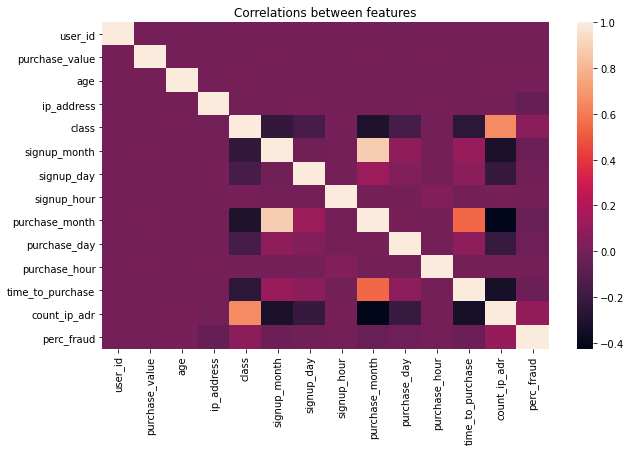

In [96]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr())
plt.title('Correlations between features')
plt.show()

In [98]:
X.isnull().sum()

signup_month        0
signup_day          0
signup_hour         0
purchase_month      0
purchase_day        0
purchase_hour       0
time_to_purchase    0
count_ip_adr        0
perc_fraud          0
dtype: int64

In [99]:
col_to_remove = ['user_id', 'signup_time', 'purchase_time',
                 'purchase_value', 'device_id', 'source', 'ip_address',
                 'browser', 'sex', 'age', 'country_name', 'signup_day_name',
                 'purchase_day_name']

X = df[[c for c in df.columns if c != 'class' and c not in col_to_remove]]
X = X.fillna(X['perc_fraud'].median())
y = df['class']



display(X.head())
display(y.head())

signup_month  signup_day  signup_hour  purchase_month  purchase_day  \
0             2          24           22               4            18   
1             6           7           20               6             8   
2             1           1           18               1             1   
3             4          28           21               5             4   
4             7          21            7               9             9   

   purchase_hour  time_to_purchase  count_ip_adr  perc_fraud  
0              2           4506682             1        9.79  
1              1             17944             1        9.56  
2             18                 1            12        9.56  
3             13            492085             1        8.57  
4             18           4361461             1        9.56

0    0
1    0
2    1
3    0
4    0
Name: class, dtype: int64

In [100]:
#cat_column = ['source', 'browser', 'sex', 'country_name', 'signup_day_name', 'purchase_day_name' ]


#cat_column_index = []
#num_column_index = []

#for i in range(len(X.columns.values)):
    #if X.columns.values[i] in cat_column:
        #cat_column_index.append(i)
    #if X.columns.values[i] not in cat_column:
        #num_column_index.append(i)    

In [101]:
#len(cat_column_index) + len (num_column_index)

In [102]:
X = X.values
y = y.to_list()

from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=19, stratify = y)

print("...Done.")
print()

print(X_train[0:5])

Dividing into train and test sets...
...Done.

[[3.000000e+00 1.600000e+01 1.700000e+01 6.000000e+00 2.900000e+01
  1.500000e+01 9.065020e+06 1.000000e+00 9.560000e+00]
 [1.000000e+00 2.600000e+01 2.100000e+01 4.000000e+00 1.800000e+01
  4.000000e+00 7.024611e+06 1.000000e+00 9.560000e+00]
 [7.000000e+00 1.100000e+01 1.400000e+01 8.000000e+00 2.800000e+01
  4.000000e+00 4.108925e+06 1.000000e+00 9.560000e+00]
 [6.000000e+00 4.000000e+00 0.000000e+00 9.000000e+00 1.500000e+01
  4.000000e+00 8.915807e+06 1.000000e+00 9.560000e+00]
 [2.000000e+00 8.000000e+00 2.000000e+01 3.000000e+00 1.300000e+01
  6.000000e+00 2.799980e+06 1.000000e+00 9.560000e+00]]


In [103]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Create pipeline for numeric features
numeric_features = [i for i in range(0, len(X[0]))] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


#from sklearn.preprocessing import OneHotEncoder

# Create pipeline for categorical features
#categorical_features = cat_column_index # Positions of categorical columns in X_train/X_test
#categorical_transformer = Pipeline(
    #steps=[
    #('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    #('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    #])


from sklearn.compose import ColumnTransformer

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
        #('cat', categorical_transformer, categorical_features)
    #])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test) # Don't fit again !!
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
[[3.000000e+00 1.600000e+01 1.700000e+01 6.000000e+00 2.900000e+01
  1.500000e+01 9.065020e+06 1.000000e+00 9.560000e+00]
 [1.000000e+00 2.600000e+01 2.100000e+01 4.000000e+00 1.800000e+01
  4.000000e+00 7.024611e+06 1.000000e+00 9.560000e+00]
 [7.000000e+00 1.100000e+01 1.400000e+01 8.000000e+00 2.800000e+01
  4.000000e+00 4.108925e+06 1.000000e+00 9.560000e+00]
 [6.000000e+00 4.000000e+00 0.000000e+00 9.000000e+00 1.500000e+01
  4.000000e+00 8.915807e+06 1.000000e+00 9.560000e+00]
 [2.000000e+00 8.000000e+00 2.000000e+01 3.000000e+00 1.300000e+01
  6.000000e+00 2.799980e+06 1.000000e+00 9.560000e+00]]
...Done.
[[-5.06900968e-01  1.45789964e-01  7.98322058e-01 -1.60503677e-03
   1.55444850e+00  5.03873598e-01  1.32087118e+00 -2.32042232e-01
   7.53293540e-02]
 [-1.39355960e+00  1.29026887e+00  1.37669867e+00 -7.53664301e-01
   3.07116126e-01 -1.08711230e+00  6.68614004e-01 -2.32042232e-01
   7.53293540e-02]
 [ 1.26641629e+00 -4.26449490e-01  3

#### Baseline model with Logistic Regression

In [104]:
from sklearn.linear_model import LogisticRegression

# Train model
model = LogisticRegression()

print("Training model...")
model.fit(X_train, y_train)
print("...Done.")

Training model...
...Done.


In [105]:
# Predictions on training set
print("Predictions on training set...")
y_train_pred = model.predict(X_train)
print("...Done.")
print(y_train_pred[0:5])
print()

y_test_pred = model.predict(X_test)
print("...Done.")
print(y_test_pred[0:5])
print()

Predictions on training set...
...Done.
[0 0 0 0 0]



In [106]:
from sklearn.metrics import accuracy_score
# Print scores
print("Accuracy on training set : ", accuracy_score(y_train, y_train_pred))
print("Accuracy on test set : ", accuracy_score(y_test, y_test_pred))

Accuracy on training set :  0.9516498606159369
Accuracy on test set :  0.9515931575290342


In [107]:
from sklearn.metrics import f1_score

print('f1 train :',f1_score(y_train, y_train_pred))
print('f1 test :',f1_score(y_test, y_test_pred))

f1 train : 0.6724205570812084
f1 test : 0.6724871278262815


[]

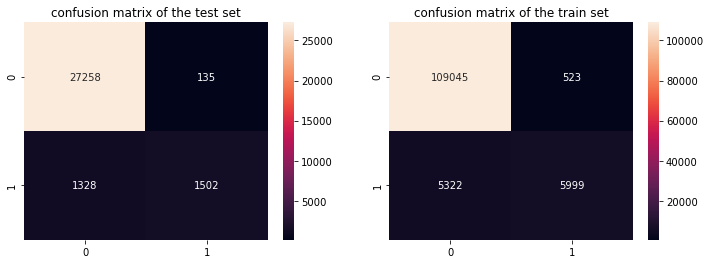

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion Matrix
from sklearn import metrics
cm_test = metrics.confusion_matrix(y_test, y_test_pred) 
cm_train = metrics.confusion_matrix(y_train, y_train_pred) 


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(cm_test, annot=True, ax = ax1, fmt=".6g" );
sns.heatmap(cm_train, annot=True, ax = ax2, fmt=".6g" );

ax1.set_title('confusion matrix of the test set')
ax2.set_title('confusion matrix of the train set')
plt.plot()

In [109]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

scores_train = cross_val_score(model, X_train, y_train, cv=10, scoring='f1')
#predictions = cross_val_predict(model, X_train, Y_train, cv = 10)

print(scores_train)
print('score min :',scores_train.min())
print('score max :',scores_train.max())
print('score mean :',scores_train.mean())

[0.67490174 0.6681465  0.68561873 0.65641026 0.6659078  0.67299107
 0.67080045 0.6807564  0.67554077 0.67264574]
score min : 0.6564102564102564
score max : 0.6856187290969898
score mean : 0.6723719451052628


In [40]:
# grid search class weights with logistic regression for imbalance classification
from numpy import mean
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# define grid
cw_params = [{0:0.6,1:1}]
#cw_params = [{0:i, 1:1} for i in np.arange(0.60, 0.7, 0.001)]
C_param = np.arange(0.9, 1.01, 0.01)
param_grid = dict(class_weight = cw_params, C = C_param)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=19)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X_test, Y_test)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: name 'Y_test' is not defined

### DECISION TREE

In [110]:
dec_tree = DecisionTreeClassifier(criterion='entropy',
                                       max_depth=5,
                                       min_samples_split= 10,
                                       min_samples_leaf= 22,
                                       max_features = 3)
dec_tree.fit(X_train, y_train)
print(dec_tree, "fitted")

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=3,
                       min_samples_leaf=22, min_samples_split=10) fitted


In [111]:
# Predictions on training set
print("Predictions on training set...")
y_train_pred = dec_tree.predict(X_train)
print("...Done.")
print(y_train_pred[0:5])
print()

print("Predictions on testing set...")
y_test_pred = dec_tree.predict(X_test)
print("...Done.")
print(y_test_pred[0:5])

Predictions on training set...
...Done.
[0 0 0 0 0]

Predictions on training set...
...Done.
[0 0 0 0 0]


[]

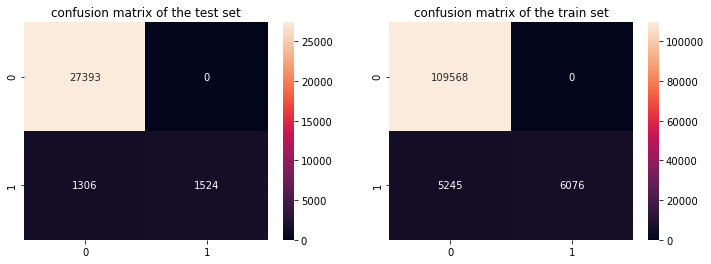

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion Matrix
from sklearn import metrics
cm_test = metrics.confusion_matrix(y_test, y_test_pred) 
cm_train = metrics.confusion_matrix(y_train, y_train_pred) 


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(cm_test, annot=True, ax = ax1, fmt=".6g" );
sns.heatmap(cm_train, annot=True, ax = ax2, fmt=".6g" );

ax1.set_title('confusion matrix of the test set')
ax2.set_title('confusion matrix of the train set')
plt.plot()

In [113]:
# Print scores
print("Accuracy on training set : ", accuracy_score(y_train, y_train_pred))
print("Accuracy on test set : ", accuracy_score(y_test, y_test_pred))

Accuracy on training set :  0.9566130913482617
Accuracy on test set :  0.9567878767825828


In [114]:
print(classification_report(y_true=y_train, y_pred=y_train_pred), "\n")
print(f"f1 score train set : {f1_score(y_train, y_train_pred)}", "\n")

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    109568
           1       1.00      0.54      0.70     11321

    accuracy                           0.96    120889
   macro avg       0.98      0.77      0.84    120889
weighted avg       0.96      0.96      0.95    120889
 

f1 score train set : 0.6985112375696959 



In [115]:
print(classification_report(y_true=y_test, y_pred = y_test_pred))
print(f"f1 score test set : {f1_score(y_test, y_test_pred)}", "\n")

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.54      0.70      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223

f1 score test set : 0.7000459347726229 



In [117]:
cv_scores = cross_val_score(dec_tree, X_train, y_train, cv=10,  scoring='f1')

print(f"Result cross-validation using K=10 : {cv_scores}", "\n")
print(f"Score mean with a cross_validation = {np.mean(cv_scores)}")
print(f"Score std with a cross_validation = {np.std(cv_scores)}")

Result cross-validation using K=10 : [0.70332188 0.69585253 0.70849971 0.68218859 0.68981481 0.69994263
 0.69434833 0.69662921 0.706621   0.69735328] 

Score mean with a cross_validation = 0.6974571987017549
Score std with a cross_validation = 0.007422648533893538


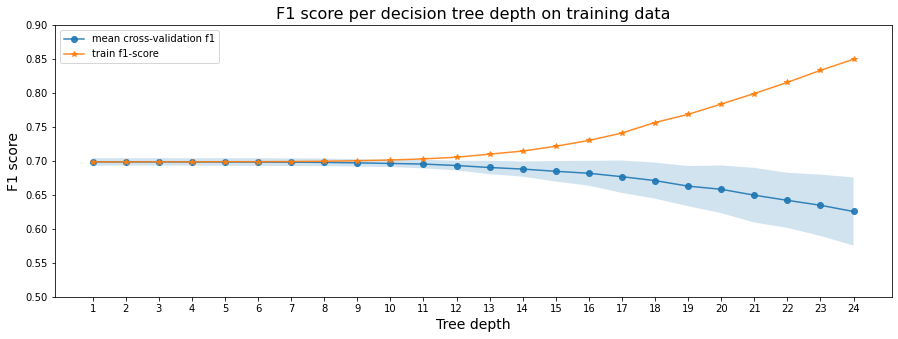

In [171]:
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='f1'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    f1_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        pred = tree_model.fit(X, y).predict(X)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        f1_scores.append(f1_score(y_train, pred))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    f1_scores = np.array(f1_scores)
    return cv_scores_mean, cv_scores_std, f1_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, f1_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation f1', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim(0.50, 0.90)
    ax.plot(depths, f1_scores, '-*', label='train f1-score', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('F1 score', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_f1_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_f1_scores, 
                               'F1 score per decision tree depth on training data')



In [141]:
# grid search with Decision Tree 


#Define parameters
parameters = {'criterion' : ['gini'], 
              'max_depth': [1],
              'min_samples_split': [2],
              'min_samples_leaf': np.arange(1, 50, 1)}
              #'max_features': list(range(1, X_train.shape[1]))}

dec_tree_grid = DecisionTreeClassifier() #create an instance of Decision Tree

# call the grid with parameters
grid = GridSearchCV(dec_tree_grid, parameters, cv=10, verbose=2, scoring="f1")
grid_fit = grid.fit(X_train, y_train) # fit the grid

#print the main results
print("Best parameters from gridsearch: {}".format(grid.best_params_), "\n")
print("CV score=%0.3f" % grid.best_score_, "\n")
cv_results = grid.cv_results_
#print(cv_results)


Fitting 10 folds for each of 49 candidates, totalling 490 fits
[CV] criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2 
[CV]  crit

[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:   35.7s finished


### Random Forest

In [157]:
rand_forest = RandomForestClassifier(n_estimators = 50)
rand_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [158]:
# Predictions on training set
print("Predictions on training set...")
y_train_pred = rand_forest.predict(X_train)
print("...Done.")
print(y_train_pred[0:5])
print()

print("Predictions on testing set...")
y_test_pred = rand_forest.predict(X_test)
print("...Done.")
print(y_test_pred[0:5])

Predictions on training set...
...Done.
[0 0 0 0 1]

Predictions on testing set...
...Done.
[0 0 0 0 0]


[]

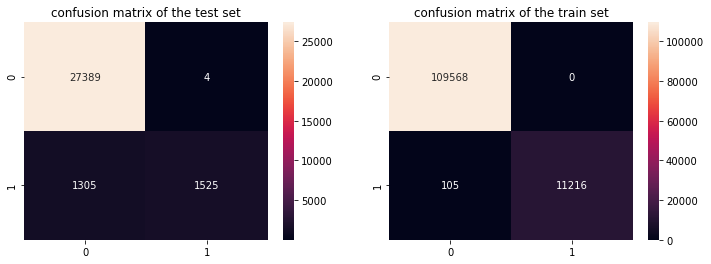

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion Matrix
from sklearn import metrics
cm_test = metrics.confusion_matrix(y_test, y_test_pred) 
cm_train = metrics.confusion_matrix(y_train, y_train_pred) 


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(cm_test, annot=True, ax = ax1, fmt=".6g" );
sns.heatmap(cm_train, annot=True, ax = ax2, fmt=".6g" );

ax1.set_title('confusion matrix of the test set')
ax2.set_title('confusion matrix of the train set')
plt.plot()

In [160]:
# Print scores
print("Accuracy on training set : ", accuracy_score(y_train, y_train_pred))
print("Accuracy on test set : ", accuracy_score(y_test, y_test_pred))

Accuracy on training set :  0.9991314346218432
Accuracy on test set :  0.9566886146312411


In [161]:
print(classification_report(y_true=y_train, y_pred=y_train_pred), "\n")
print(f"f1 score train set : {f1_score(y_train, y_train_pred)}", "\n")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    109568
           1       1.00      0.99      1.00     11321

    accuracy                           1.00    120889
   macro avg       1.00      1.00      1.00    120889
weighted avg       1.00      1.00      1.00    120889
 

f1 score train set : 0.9953409948085371 



In [162]:
print(classification_report(y_true=y_test, y_pred = y_test_pred))
print(f"f1 score test set : {f1_score(y_test, y_test_pred)}", "\n")

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.54      0.70      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223

f1 score test set : 0.6997017664601974 



In [163]:
cv_scores = cross_val_score(rand_forest, X_train, y_train, cv=10,  scoring='f1')

print(f"Result cross-validation using K=10 : {cv_scores}", "\n")
print(f"Score mean with a cross_validation = {np.mean(cv_scores)}")
print(f"Score std with a cross_validation = {np.std(cv_scores)}")

Result cross-validation using K=10 : [0.70211549 0.69585253 0.70728929 0.68139535 0.6886193  0.70034443
 0.69394813 0.70628571 0.70541311 0.69735328] 

Score mean with a cross_validation = 0.6978616624841937
Score std with a cross_validation = 0.007856844470021915


In [164]:
# grid search with Decision Tree 


#Define parameters
parameters = {'n_estimators': np.arange(1, 100, 1)}
              #'criterion' : ['gini'], 
              #'max_depth': [1],
              #'min_samples_split': [2],
              #'min_samples_leaf': np.arange(1, 50, 1)}
              #'max_features': list(range(1, X_train.shape[1]))}

rand_forest_grid = RandomForestClassifier() #create an instance of Random Forest

# call the grid with parameters
grid = GridSearchCV(rand_forest_grid, parameters, cv=10, verbose=2, scoring="f1")
grid_fit = grid.fit(X_train, y_train) # fit the grid

#print the main results
print("Best parameters from gridsearch: {}".format(grid.best_params_), "\n")
print("CV score=%0.3f" % grid.best_score_, "\n")
cv_results = grid.cv_results_
#print(cv_results)


Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV] n_estimators=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... n_estimators=1, total=   0.2s
[CV] n_estimators=1 ..................................................
[CV] ................................... n_estimators=1, total=   0.2s
[CV] n_estimators=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................................... n_estimators=1, total=   0.2s
[CV] n_estimators=1 ..................................................
[CV] ................................... n_estimators=1, total=   0.1s
[CV] n_estimators=1 ..................................................
[CV] ................................... n_estimators=1, total=   0.2s
[CV] n_estimators=1 ..................................................
[CV] ................................... n_estimators=1, total=   0.2s
[CV] n_estimators=1 ..................................................
[CV] ................................... n_estimators=1, total=   0.2s
[CV] n_estimators=1 ..................................................
[CV] ................................... n_estimators=1, total=   0.2s
[CV] n_estimators=1 ..................................................
[CV] ................................... n_estimators=1, total=   0.2s
[CV] n_estimators=1 ..................................................
[CV] .

KeyboardInterrupt: 

### SVM

In [172]:
%%time

svc_instance = SVC(kernel='rbf', class_weight = 'balanced')
svc_instance.fit(X_train, y_train)
print(svc_instance, "created !")

SVC(class_weight='balanced') created !
CPU times: user 44min 51s, sys: 5.61 s, total: 44min 57s
Wall time: 44min 59s


In [173]:
%%time

# Predictions on training set
print("Predictions on training set...")
y_train_pred = svc_instance.predict(X_train)
print("...Done.")
print(y_train_pred[0:5])
print()

print("Predictions on testing set...")
y_test_pred = svc_instance.predict(X_test)
print("...Done.", "\n")
print(y_test_pred[0:5])

Predictions on training set...
...Done.
[0 0 0 0 0]

Predictions on testing set...
...Done. 

[0 0 0 0 0]
CPU times: user 2min 28s, sys: 389 ms, total: 2min 28s
Wall time: 2min 29s


[]

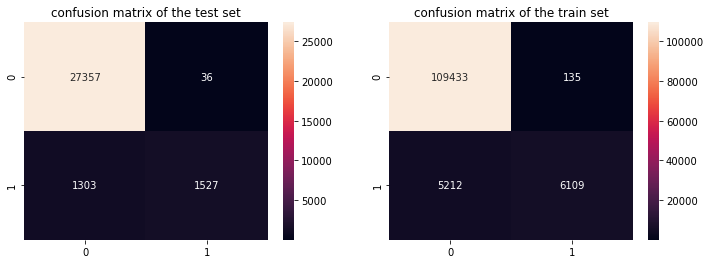

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion Matrix
from sklearn import metrics
cm_test = metrics.confusion_matrix(y_test, y_test_pred) 
cm_train = metrics.confusion_matrix(y_train, y_train_pred) 


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(cm_test, annot=True, ax = ax1, fmt=".6g" );
sns.heatmap(cm_train, annot=True, ax = ax2, fmt=".6g" );

ax1.set_title('confusion matrix of the test set')
ax2.set_title('confusion matrix of the train set')
plt.plot()

In [175]:
# Print scores
print("Accuracy on training set : ", accuracy_score(y_train, y_train_pred))
print("Accuracy on test set : ", accuracy_score(y_test, y_test_pred))

Accuracy on training set :  0.9557693421237664
Accuracy on test set :  0.9556959931178242


In [176]:
print(classification_report(y_true=y_train, y_pred=y_train_pred), "\n")
print(f"f1 score train set : {f1_score(y_train, y_train_pred)}", "\n")

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    109568
           1       0.98      0.54      0.70     11321

    accuracy                           0.96    120889
   macro avg       0.97      0.77      0.84    120889
weighted avg       0.96      0.96      0.95    120889
 

f1 score train set : 0.6955878166808996 



In [177]:
print(classification_report(y_true=y_test, y_pred = y_test_pred))
print(f"f1 score test set : {f1_score(y_test, y_test_pred)}", "\n")

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.98      0.54      0.70      2830

    accuracy                           0.96     30223
   macro avg       0.97      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223

f1 score test set : 0.6951969041657182 



In [178]:
cv_scores = cross_val_score(dec_tree, X_train, y_train, cv=10,  scoring='f1')

print(f"Result cross-validation using K=10 : {cv_scores}", "\n")
print(f"Score mean with a cross_validation = {np.mean(cv_scores)}")
print(f"Score std with a cross_validation = {np.std(cv_scores)}")

Result cross-validation using K=10 : [0.70332188 0.69585253 0.70849971 0.68060395 0.68941585 0.70034443
 0.69434833 0.70628571 0.70621791 0.69695227] 

Score mean with a cross_validation = 0.6981842581234416
Score std with a cross_validation = 0.008217449230844397
